# Mink FCN usage examples

This is a notebook showcasing a simple application of fully convolutional networks (FCNs). The task is to take an MNIST image as input and turn it on its head.

## Imports

In [1]:
import os

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.utils import shuffle
import tensorflow as tf
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
from mink import NeuralNetRegressor
from mink.layers import DenseLayer
from mink.layers import InputLayer
from mink.layers import Conv2DLayer
from mink.layers import DropoutLayer
from mink.layers import MaxPool2DLayer
from mink.layers import ImageResizeLayer
from mink.layers import ConcatLayer
from mink.nonlinearities import Softmax
from mink import updates

## Load MNIST data

In [4]:
path = os.path.join(os.path.expanduser('~'), 'data/mnist/train.csv')
df = pd.read_csv(path)

In [5]:
y = df.pop('label')

In [6]:
X = (df.values / 255.).astype(np.float32)

In [7]:
X.shape

(42000, 784)

In [8]:
X = X.reshape(-1, 28, 28, 1)

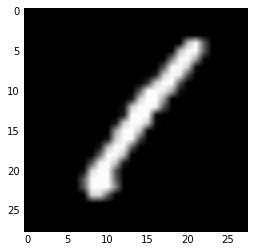

In [9]:
plt.imshow(X[0, :, :, 0], cmap='gray')

In [10]:
X, y = shuffle(X, y)

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8)

## Train the FCN

In [12]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
session_kwargs = {'config': tf.ConfigProto(gpu_options=gpu_options)}

In [13]:
def sigmoid(x):
    return 1 / (1 + tf.exp(-x))

In [14]:
l_inp = InputLayer(ys=tf.placeholder('float32', shape=(None, 28, 28, 1)))

l_c01 = Conv2DLayer(l_inp, num_filters=32)
l_c02 = Conv2DLayer(l_c01, num_filters=32)
l_p03 = MaxPool2DLayer(l_c02)

l_c11 = Conv2DLayer(l_p03, num_filters=64)
l_c12 = Conv2DLayer(l_c11, num_filters=64)
l_p13 = MaxPool2DLayer(l_c12)

# bottom
l_c20 = Conv2DLayer(l_p13, num_filters=64)
l_c21 = Conv2DLayer(l_c20, num_filters=64)

l_u14 = ImageResizeLayer(l_c21)
l_m15 = ConcatLayer([l_u14, l_c12], axis=3)
l_c16 = Conv2DLayer(l_m15, num_filters=64)
l_c17 = Conv2DLayer(l_c16, num_filters=64)

l_u04 = ImageResizeLayer(l_c17)
l_m05 = ConcatLayer([l_u04, l_c02], axis=3)
l_c06 = Conv2DLayer(l_m05, num_filters=32)
l_c07 = Conv2DLayer(l_c06, num_filters=32)

l_out = Conv2DLayer(l_c07, num_filters=1, filter_size=1, nonlinearity=sigmoid)

In [15]:
all_layers = [l_inp, l_c01, l_c02, l_p03, l_c11, l_c12, l_p13, l_c20, l_c21, l_u14,
              l_m15, l_c16, l_c17, l_u04, l_m05, l_c06, l_c07, l_out]

Note: Instead of passing `all_layers`, we could simply pass `l_out` to the `layer` argument of `NeuralNetRegressor`. The reason why we don't do this here is because in the second case, the order of the layers printed below would look "unnatural". Functionally, though, both ways lead to the same outcome.

In [16]:
net = NeuralNetRegressor(
    layer=all_layers, 
    max_epochs=20, 
    verbose=1, 
    #update=updates.Adagrad(0.001),
    update=updates.Adadelta(4),
    session_kwargs=session_kwargs,
)

In [17]:
net.fit(X_train, X_train[:, ::-1])

# Neural Network with 286529 learnable parameters

## Layer information

|   # | name        | size      |
|----:|:------------|:----------|
|   0 | input       | 28x28x1   |
|   1 | conv2d      | 28x28x32  |
|   2 | conv2d      | 28x28x32  |
|   3 | maxpool2d   | 14x14x32  |
|   4 | conv2d      | 14x14x64  |
|   5 | conv2d      | 14x14x64  |
|   6 | maxpool2d   | 7x7x64    |
|   7 | conv2d      | 7x7x64    |
|   8 | conv2d      | 7x7x64    |
|   9 | imageresize | 14x14x64  |
|  10 | concat      | 14x14x128 |
|  11 | conv2d      | 14x14x64  |
|  12 | conv2d      | 14x14x64  |
|  13 | imageresize | 28x28x64  |
|  14 | concat      | 28x28x96  |
|  15 | conv2d      | 28x28x32  |
|  16 | conv2d      | 28x28x32  |
|  17 | conv2d      | 28x28x1   |

|   epoch |   train loss |      dur |
|--------:|-------------:|---------:|
|       1 |      0.07939 | 51.35720 |
|       2 |      0.07031 | 51.02408 |
|       3 |      0.06678 | 51.28929 |
|       4 |      0.06268 | 51.02330 |
|       5 |      0

NeuralNetRegressor(batch_iterator_test=128, batch_iterator_train=128,
          encoder=None,
          layer=[InputLayer(Xs=None, make_logs=False, name=None,
      ys=<tf.Tensor 'Placeholder:0' shape=(?, 28, 28, 1) dtype=float32>), Conv2DLayer(W=GlorotUniform(c01b=False, gain=1.0), b=Constant(value=0.0),
      filter_size=3,
      incoming=InputLayer(Xs=None, make_logs=False, name=None,
      ys=<tf....  nonlinearity=<function sigmoid at 0x7fc4fce877b8>, num_filters=1,
      padding='SAME', stride=1)],
          max_epochs=20, objective=MeanSquaredError(),
          on_epoch_finished=(PrintTrainProgress(first_iteration=False, floatfmt='.5f', tablefmt='pipe'),),
          on_training_started=(PrintLayerInfo(tablefmt='pipe'),),
          session_kwargs={'config': gpu_options {
  per_process_gpu_memory_fraction: 0.5
}
},
          update=Adadelta(learning_rate=4, rho=0.95), verbose=1)

## Predict on new images

In [18]:
%time y_pred = net.predict(X_valid)

CPU times: user 3.8 s, sys: 100 ms, total: 3.9 s
Wall time: 4.46 s


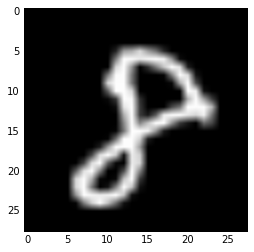

In [19]:
plt.imshow(X_valid[0, :, :, 0], cmap='gray')

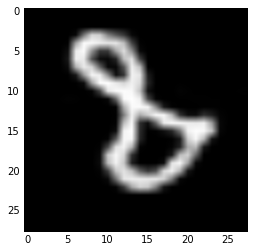

In [20]:
plt.imshow(y_pred[0, :, :, 0], cmap='gray')

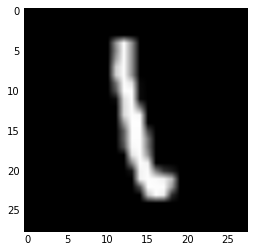

In [21]:
plt.imshow(X_valid[110, :, :, 0], cmap='gray')

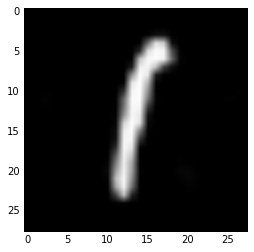

In [22]:
plt.imshow(y_pred[110, :, :, 0], cmap='gray')